# Your First AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) from Oxford of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load the image dataset and create a pipeline.
* Build and Train an image classifier on this dataset.
* Use your trained model to perform inference on flower images.

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

## Install Datasets and Upgrade TensorFlow

To ensure we can download the latest version of the `oxford_flowers102` dataset, let's first install both `tensorflow-datasets` and `tfds-nightly`.
* `tensorflow-datasets` is the stable version that is released on a cadence of every few months
* `tfds-nightly` is released every day and has the latest version of the datasets

We'll also upgrade TensorFlow to ensure we have a version that is compatible with the latest version of the dataset.

In [1]:
%pip --no-cache-dir install tensorflow-datasets --user
%pip --no-cache-dir install tfds-nightly --user
%pip --no-cache-dir install --upgrade tensorflow --user

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Requirement already up-to-date: tensorflow in /root/.local/lib/python3.7/site-packages (2.9.1)


Note: you may need to restart the kernel to use updated packages.


After the above installations have finished **be sure to restart the kernel**. You can do this by going to **Kernel > Restart**.

In [2]:
# Import TensorFlow 
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub

# Ignore some warnings that are not relevant (you can remove this if you prefer)
import warnings
warnings.filterwarnings('ignore')

In [3]:
# TODO: Make all other necessary imports.
# Numpy: converting tf tensors to np arrays
import numpy as np
# Matplotlib: Plotting of different contexts (showing images or plotting metrics)
import matplotlib.pyplot as plt
# JSON: reading the label map file
import json
# Workspcae Utils: keeping the session active while doing long tasks (e.g. training)
from workspace_utils import active_session
# PIL Image: opening images
from PIL import Image

In [4]:
# Some other recommended settings:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
tfds.disable_progress_bar()

## Load the Dataset

Here you'll use `tensorflow_datasets` to load the [Oxford Flowers 102 dataset](https://www.tensorflow.org/datasets/catalog/oxford_flowers102). This dataset has 3 splits: `'train'`, `'test'`, and `'validation'`.  You'll also need to make sure the training data is normalized and resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet, but you'll still need to normalize and resize the images to the appropriate size.

In [5]:
# TODO: Load the dataset with TensorFlow Datasets. Hint: use tfds.load()
# Set split proportions
train_split = 60
test_val_split = 20
# Use .load function to load the flower dataset with the stated splits and info
dataset, dataset_info = tfds.load('oxford_flowers102', split=['train[:60%]', 'test[:20%]','validation[:20%]'], as_supervised=True, with_info=True)

In [6]:
# TODO: Create a training set, a validation set and a test set
training_set, validation_set, test_set = dataset

## Explore the Dataset

In [7]:
# TODO: Get the number of examples in each set from the dataset info.
# Number of Training Samples
training_samples = dataset_info.splits["test"].num_examples
print("Training Samples:", training_samples)
# Number of Testing Samples
testing_samples = dataset_info.splits["train"].num_examples
print("Testing Samples:",testing_samples)
# Number of Validation Samples
val_samples = dataset_info.splits["validation"].num_examples
print("Validation Samples:", val_samples)

Training Samples: 6149
Testing Samples: 1020
Validation Samples: 1020


In [8]:
# TODO: Get the number of classes in the dataset from the dataset info.
num_classes =  dataset_info.features["label"].num_classes
print("Classes:",num_classes)

Classes: 102


In [9]:
# TODO: Print the shape and corresponding label of 3 images in the training set.
# Iterate over 3 images
for image, label in training_set.take(3):
    # Convert the label to numpy datatype (for better string conversion)
    label = label.numpy()
    print("Shape:",image.shape,"Label:",label)

Shape: (500, 667, 3) Label: 72
Shape: (500, 666, 3) Label: 84
Shape: (670, 500, 3) Label: 70


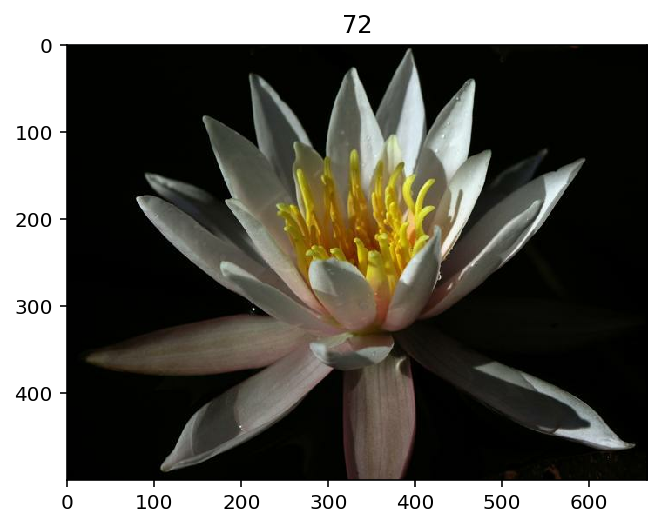

In [10]:
# TODO: Plot 1 image from the training set. 
# Set the title of the plot to the corresponding image label.

# Take one image from training set
for image, label in training_set.take(1):
    # Conversion of label and image to numpy form
    image = image.numpy().squeeze()
    label = label.numpy()
# Show the image using matplotlib
plt.imshow(image)
# Set the title of the plot
plt.title(label)
plt.show()

### Label Mapping

You'll also need to load in a mapping from label to category name. You can find this in the file `label_map.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/3.7/library/json.html). This will give you a dictionary mapping the integer coded labels to the actual names of the flowers.

In [11]:
# Open and load the json file
with open('label_map.json', 'r') as f:
    class_names = json.load(f)

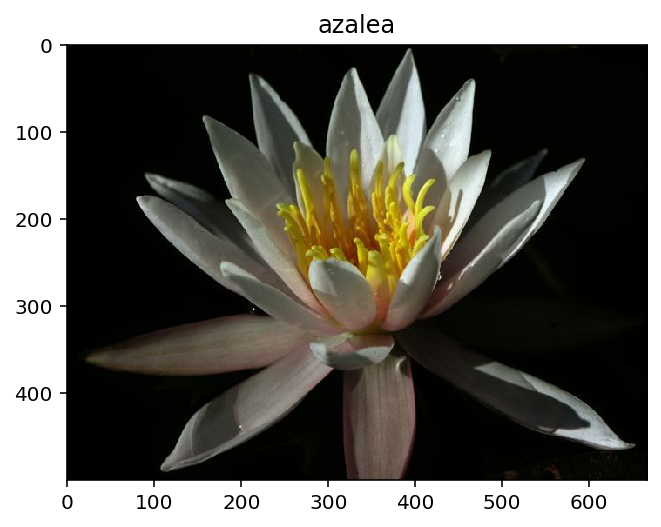

In [12]:
# TODO: Plot 1 image from the training set. Set the title 
# of the plot to the corresponding class name. 

# Take one image 
for image, label in training_set.take(1):
    # Conversion of image and label to numpy data type
    image = image.numpy().squeeze()
    label = label.numpy()
# Show the image using matplotlib
plt.imshow(image)
# Set the title of the image using the loaded json-map
plt.title(class_names[str(label)])
plt.show()

## Create Pipeline

In [13]:
# TODO: Create a pipeline for each set.

# Setting size for one batch
batch_size = 64
# Setting the image size (224x224)
img_size = 224

# Formatting function
def norm_img(image, label):
    # Cast the type (float tensor)
    image = tf.cast(image, tf.float32)
    # Resize the image to given constraints (img_size)
    image = tf.image.resize(image, (img_size, img_size))
    # Divide by max value (normalize)
    image /= 255
    return image, label

# Create batches
training_batches = training_set.shuffle(training_samples//3).map(norm_img).batch(batch_size).prefetch(1)
testing_batches = test_set.map(norm_img).batch(batch_size).prefetch(1)
validation_batches = validation_set.map(norm_img).batch(batch_size).prefetch(1)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


# Build and Train the Classifier

Now that the data is ready, it's time to build and train the classifier. You should use the MobileNet pre-trained model from TensorFlow Hub to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. If you want to talk through it with someone, chat with your fellow students! 

Refer to the rubric for guidance on successfully completing this section. Things you'll need to do:

* Load the MobileNet pre-trained network from TensorFlow Hub.
* Define a new, untrained feed-forward network as a classifier.
* Train the classifier.
* Plot the loss and accuracy values achieved during training for the training and validation set.
* Save your trained model as a Keras model. 

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right.

**Note for Workspace users:** One important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module. Also, If your model is over 1 GB when saved as a checkpoint, there might be issues with saving backups in your workspace. If your saved checkpoint is larger than 1 GB (you can open a terminal and check with `ls -lh`), you should reduce the size of your hidden layers and train again.

In [14]:
# TODO: Build and train your network.

# Setting URL of the model
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
# Loading the pretrained model using tfhub
pretrained = hub.KerasLayer(URL, input_shape=(img_size, img_size,3))
# Avoid training of pretrained parameters
pretrained.trainable = False

In [15]:
# Define the model
# Keep simplicity => avoid overfitting
# Set number of output-neurons to be the number of classes
model = tf.keras.Sequential([
        pretrained,
        tf.keras.layers.Dense(num_classes, activation = 'softmax')
])
# Get a model summary
model.summary()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 102)               130662    
                                                                 
Total params: 2,388,646
Trainable params: 130,662
Non-trainable params: 2,257,984
_________________________________________________________________


In [16]:
# Compile the model using the learned parameters and accuracy metric
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [17]:
# Stop training early
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
# Declare epochs (rather too many, because of early stopping)
EPOCHS = 50

In [18]:
# Train the model while keeping the session active
with active_session():
    # Get history map
    history = model.fit(training_batches,
                        epochs=EPOCHS,
                        validation_data=validation_batches,
                        callbacks=[early_stop])

Epoch 1/50
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
10/10 [==============================] - ETA: 0s - loss: 4.6595 - accuracy: 0.0245WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7fe0d484def0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
10/10 [==============================] - 41s 4s/step - loss: 4.6595 - accuracy: 0.0245 - val_loss: 4.0276 - val_accuracy: 0.1268
Epoch 2/50
10/10 [==============================] - 36s 4s/step - loss: 3.2974 - accuracy: 0.3317 - val_loss: 3.3449 - val_accuracy: 0.3065
Epoch 3/50
10/10 [==============================] - 36s 4s/step - loss: 2.3307 - accuracy: 0.6748 - val_loss: 2.7904 - val_accuracy: 0.4488
Epoch 4/50
10/10 [==============================] - 36s 4s/step - loss: 1.6196 - accuracy: 0.8578 - val_loss: 2.3812 - val_accuracy: 0.5528
Epoch 5/50
10/10 [==============================] - 36s 4s/step - loss: 1.1500 - accuracy: 0.9281 - val_loss: 2.1308 - val_accuracy: 0.5862


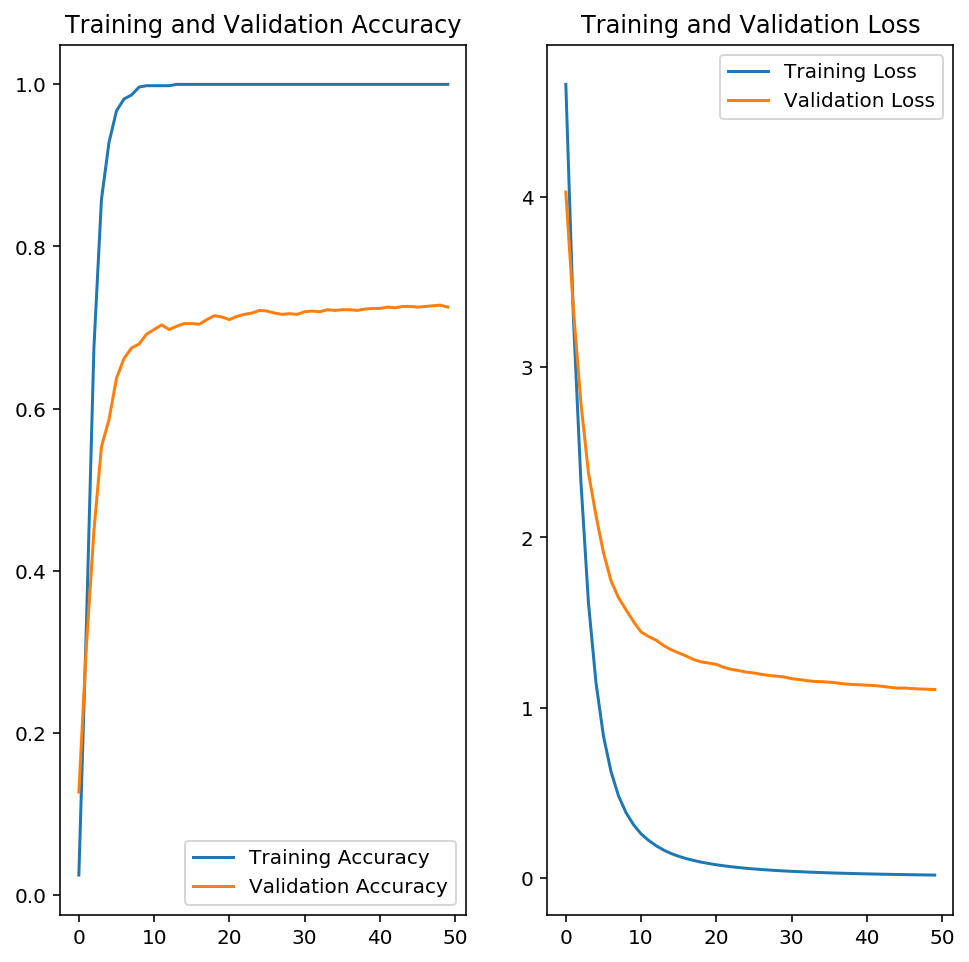

In [19]:
# TODO: Plot the loss and accuracy values achieved during training for the training and validation set.

# Get the stats out of the history map
training_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
training_loss = history.history['loss']
val_loss = history.history['val_loss']

# X-Values for graph (epoch progress)
epochs=[i for i in range(EPOCHS)]

# Using Layout from earlier lessons
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs, training_accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs, training_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()


## Testing your Network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [20]:
# TODO: Print the loss and accuracy values achieved on the entire test set.

# Predict on testing batches
loss, accuracy = model.evaluate(testing_batches)

print('Loss (testing set)',loss)
print('Accuracy (testing set)',accuracy)

4/4 [==============================] - 4s 847ms/step - loss: 1.1704 - accuracy: 0.7010
Loss (testing set) 1.1704405546188354
Accuracy (testing set) 0.7009803652763367


## Save the Model

Now that your network is trained, save the model so you can load it later for making inference. In the cell below save your model as a Keras model (*i.e.* save it as an HDF5 file).

In [21]:
filepath ='./main.h5'

In [22]:
model.save(filepath)

## Load the Keras Model

Load the Keras model you saved above.

In [23]:
# TODO: Load the Keras model

# error when trying to reload the model: Unknown layer: KerasLayer
# It's probably because of the transfer-learning layer (MobileKit)
# thats why the custom_object is needed 
reloaded_model = tf.keras.models.load_model(filepath,custom_objects={'KerasLayer':hub.KerasLayer})
reloaded_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 102)               130662    
                                                                 
Total params: 2,388,646
Trainable params: 130,662
Non-trainable params: 2,257,984
_________________________________________________________________


# Inference for Classification

Now you'll write a function that uses your trained network for inference. Write a function called `predict` that takes an image, a model, and then returns the top $K$ most likely class labels along with the probabilities. The function call should look like: 

```python
probs, classes = predict(image_path, model, top_k)
```

If `top_k=5` the output of the `predict` function should be something like this:

```python
probs, classes = predict(image_path, model, 5)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

Your `predict` function should use `PIL` to load the image from the given `image_path`. You can use the [Image.open](https://pillow.readthedocs.io/en/latest/reference/Image.html#PIL.Image.open) function to load the images. The `Image.open()` function returns an `Image` object. You can convert this `Image` object to a NumPy array by using the `np.asarray()` function.

The `predict` function will also need to handle pre-processing the input image such that it can be used by your model. We recommend you write a separate function called `process_image` that performs the pre-processing. You can then call the `process_image` function from the `predict` function. 

### Image Pre-processing

The `process_image` function should take in an image (in the form of a NumPy array) and return an image in the form of a NumPy array with shape `(224, 224, 3)`.

First, you should convert your image into a TensorFlow Tensor and then resize it to the appropriate size using `tf.image.resize`.

Second, the pixel values of the input images are typically encoded as integers in the range 0-255, but the model expects the pixel values to be floats in the range 0-1. Therefore, you'll also need to normalize the pixel values. 

Finally, convert your image back to a NumPy array using the `.numpy()` method.

In [24]:
# TODO: Create the process_image function
def process_image(img):
    # Same functionality is similar to the earlier normalize image function (pipeline)
    # Cast the type (float tensor)
    tensor = tf.cast(img, tf.float32)
    # Resize the image to given constraints (img_size)
    image = tf.image.resize(tensor, (img_size, img_size))
    # Divide by max value (normalize)
    image /= 255
    return image

To check your `process_image` function we have provided 4 images in the `./test_images/` folder:

* cautleya_spicata.jpg
* hard-leaved_pocket_orchid.jpg
* orange_dahlia.jpg
* wild_pansy.jpg

The code below loads one of the above images using `PIL` and plots the original image alongside the image produced by your `process_image` function. If your `process_image` function works, the plotted image should be the correct size. 

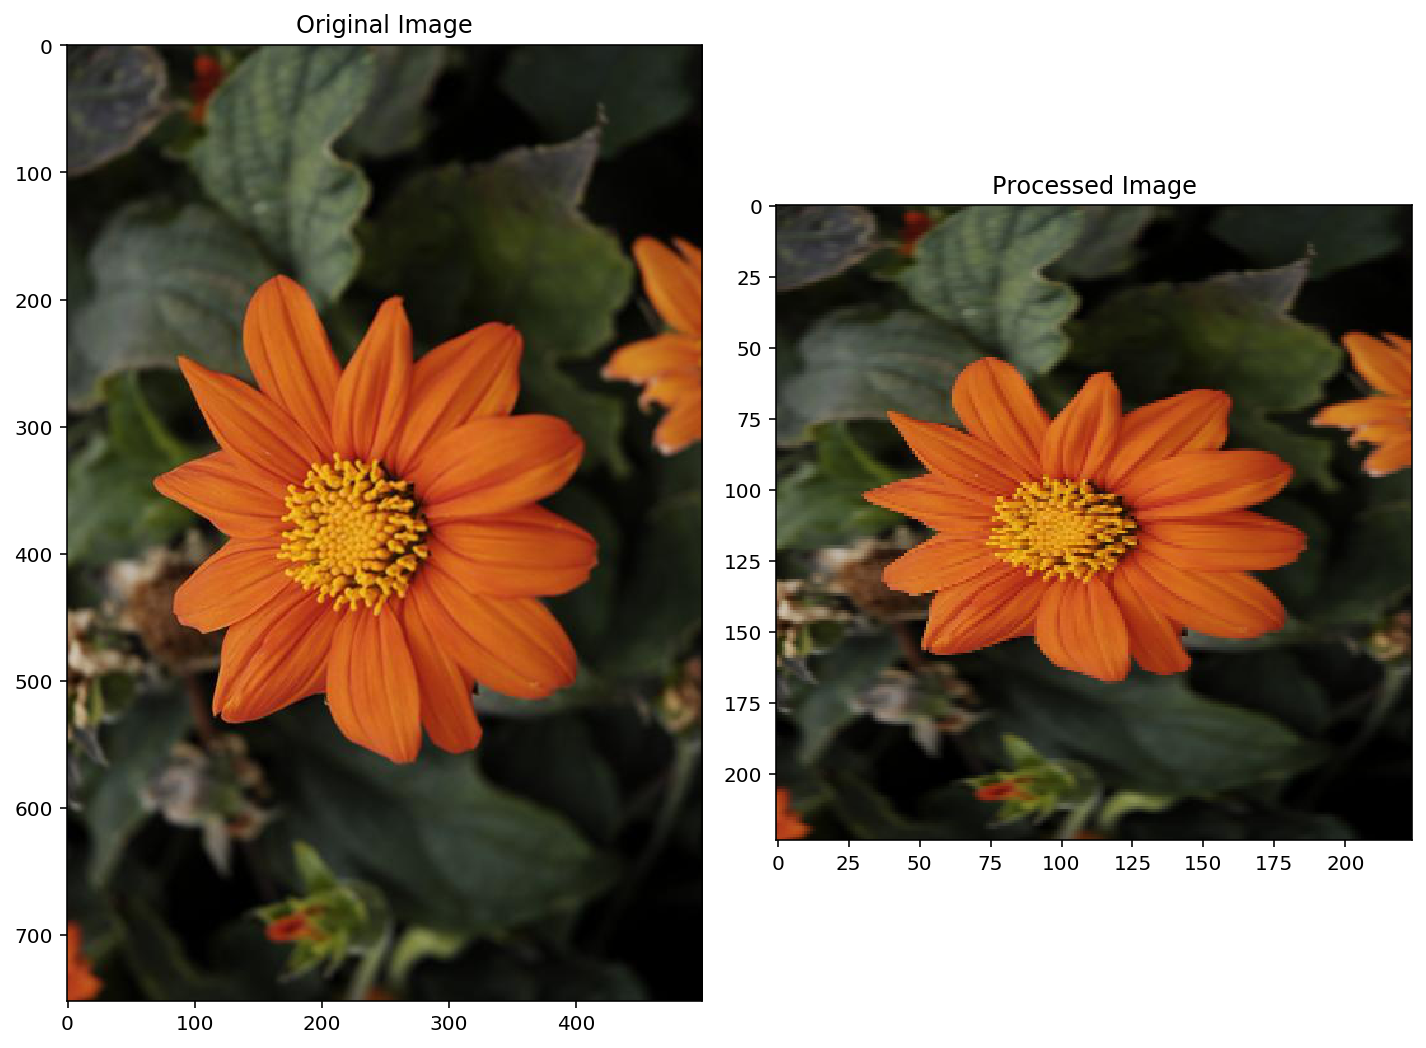

In [25]:
from PIL import Image

image_path = './test_images/orange_dahlia.jpg'
im = Image.open(image_path)
test_image = np.asarray(im)

processed_test_image = process_image(test_image)

fig, (ax1, ax2) = plt.subplots(figsize=(10,10), ncols=2)
ax1.imshow(test_image)
ax1.set_title('Original Image')
ax2.imshow(processed_test_image)
ax2.set_title('Processed Image')
plt.tight_layout()
plt.show()

Once you can get images in the correct format, it's time to write the `predict` function for making inference with your model.

### Inference

Remember, the `predict` function should take an image, a model, and then returns the top $K$ most likely class labels along with the probabilities. The function call should look like: 

```python
probs, classes = predict(image_path, model, top_k)
```

If `top_k=5` the output of the `predict` function should be something like this:

```python
probs, classes = predict(image_path, model, 5)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

Your `predict` function should use `PIL` to load the image from the given `image_path`. You can use the [Image.open](https://pillow.readthedocs.io/en/latest/reference/Image.html#PIL.Image.open) function to load the images. The `Image.open()` function returns an `Image` object. You can convert this `Image` object to a NumPy array by using the `np.asarray()` function.

**Note:** The image returned by the `process_image` function is a NumPy array with shape `(224, 224, 3)` but the model expects the input images to be of shape `(1, 224, 224, 3)`. This extra dimension represents the batch size. We suggest you use the `np.expand_dims()` function to add the extra dimension. 

In [26]:
# TODO: Create the predict function
def predict(image_path, model, top_k):
    # Open the image (PIL Image Object)
    img = Image.open(image_path)
    # Convert Image Object to np array
    img_raw = np.asarray(img)
    # Process Image
    img_processed = process_image(img_raw)
    # Expand dimension (add 1 to shape)
    img_expanded = np.expand_dims(img_processed,axis=0)
    # Make a prediction using the model
    prediction = model.predict(img_expanded)
    # Get indices of top_k values
    # using index sorting
    indices = prediction[0].argsort()[-top_k:]
    # Get the values of the top_k indices
    probs = prediction[0][indices]
    # Convert the indices to class_names (change to 1-based labels)
    classes = np.array([class_names[str(i+1)] for i in indices])
    # Return the classes and results
    return probs,classes

# Sanity Check

It's always good to check the predictions made by your model to make sure they are correct. To check your predictions we have provided 4 images in the `./test_images/` folder:

* cautleya_spicata.jpg
* hard-leaved_pocket_orchid.jpg
* orange_dahlia.jpg
* wild_pansy.jpg

In the cell below use `matplotlib` to plot the input image alongside the probabilities for the top 5 classes predicted by your model. Plot the probabilities as a bar graph. The plot should look like this:

<img src='assets/inference_example.png' width=600px>

You can convert from the class integer labels to actual flower names using `class_names`. 

In [27]:
# Name of Image
img_name = "cautleya_spicata"
# Set path of image
path = f"./test_images/{img_name}.jpg"
# Predict using the predict function
probs,classes = predict(path, reloaded_model, 5)
# Open the image using PIL 
img = Image.open(path)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1/1 [==============================] - 1s 560ms/step


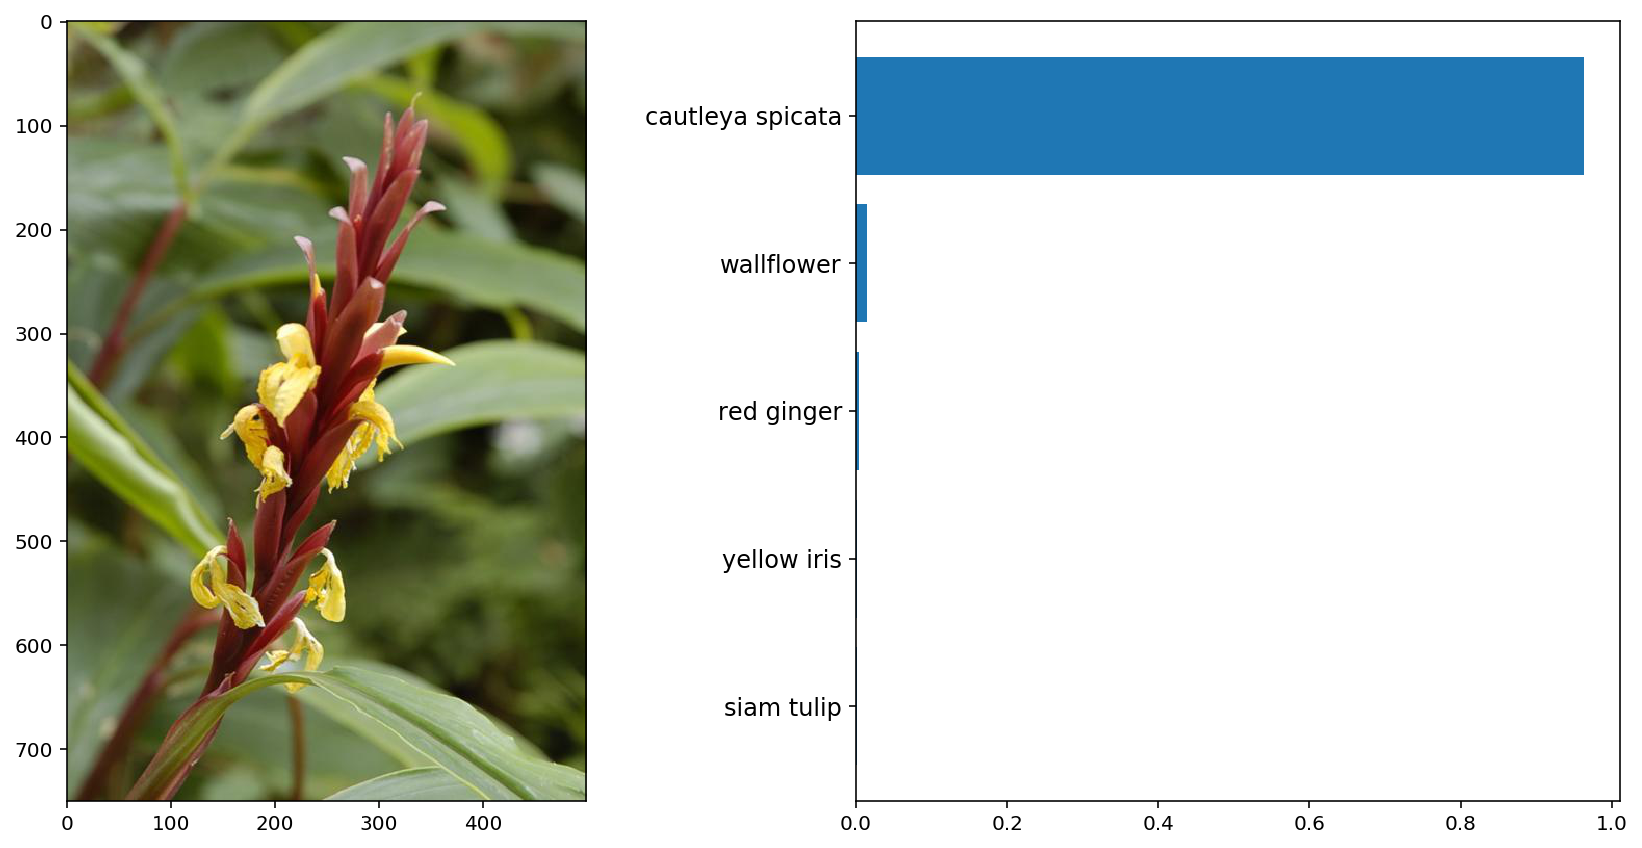

In [28]:
# TODO: Plot the input image along with the top 5 classes
fig, axes = plt.subplots(ncols=2, figsize=(12,6))
axes[0].imshow(img)
axes[1].barh(classes,probs)
axes[1].set_yticklabels(classes, fontsize=12)
plt.tight_layout()

In [30]:
# Convert Jupyter Notebook to HTML
!!jupyter nbconvert *.ipynb

['[NbConvertApp] Converting notebook Project_Image_Classifier_Project.ipynb to html',
 '[NbConvertApp] Writing 2573416 bytes to Project_Image_Classifier_Project.html']